<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9C%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D1%81%D0%BA%D0%B0%D0%BD%D0%B5%D1%80_%D0%B4%D0%BE%D0%BA%D1%83%D0%BC%D0%B5%D0%BD%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Мобильный сканер документов
# Mobile Document Scanner

Создание сканера документов с помощью OpenCV можно выполнить всего за три простых шага:


Creating a document scanner with OpenCV can be done in just three easy steps:

Шаг 1: Определяем края. Define the edges.

Шаг 2: Используем края изображения, чтобы найти контур, представляющий сканируемый лист бумаги. Use the edges of the image to find the outline that represents the sheet of paper being scanned.

Шаг 3. Применяем перспективное преобразование, чтобы получить вид документа сверху. Apply perspective transform to get a top view of the document.



### Загрузка файлов
### Download the code zip file

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_23.document_scanner.zip
!unzip -qq Lesson_23.document_scanner.zip
%cd /content/Lesson_23.document_scanner/

--2022-02-10 06:42:37--  http://dataudt.ru/datasets/cv/Lesson_23.document_scanner.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5611894 (5.4M) [application/zip]
Saving to: ‘Lesson_23.document_scanner.zip’

Lesson_23.document_ 100%[===================>]   5.35M  5.41MB/s    in 1.0s    

2022-02-10 06:42:39 (5.41 MB/s) - ‘Lesson_23.document_scanner.zip’ saved [5611894/5611894]

/content/Lesson_23.document_scanner


### Импорт библиотек
### Import Packages

In [2]:
# импортируем необходимые библиотеки
# import the necessary packages
from skimage.filters import threshold_local
from matplotlib import pyplot as plt
import numpy as np
import cv2
import imutils

### Функция отображения изображений в Jupyter Notebooks и Google Colab
### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его 
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(10,10))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Как создать потрясающий мобильный сканер документов всего за 5 минут
### How To Build a Kick-Ass Mobile Document Scanner in Just 5 Minutes

In [10]:
# явно укажем аргументы необходимые для работы
# image - Путь к сканируемому изображению

# explicitly specify the arguments needed to work
# image - Path to the image to be scanned
args = {
	"image": "images/page_2.jpg"
}

In [5]:
def four_point_transform(image, pts):
    # получаем согласованный порядок точек и отдельно распаковываем их
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

    # вычисляем ширину нового изображения, которое будет
	# максимальным расстоянием между нижней правой и нижней левой
	# x-координатами или верхней правой и верхней левой x-координатами
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

    # вычисляем высоту нового изображения, которая будет
	# максимальным расстоянием между верхней правой и нижней правой
	# y-координатами или верхней левой и нижней левой координатами y
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

    # теперь, когда у нас есть размеры нового изображения, создадим
	# набор точек для просмотра "с высоты птичьего полета",
	# (т.е. вид сверху вниз) изображения, опять же с указанием точек
	# в верхнем левом, верхнем правом, нижнем правом и нижнем левом углах
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

    # вычисляем матрицу перспективного преобразования и затем применяем ее
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # возвращаем деформированное изображение
	# return the warped image
	return warped

In [6]:
def order_points(pts):
	# создаем список координат, которые будут упорядочены
	# таким образом, чтобы первая запись в списке находилась в верхнем левом углу,
	# вторая запись находится справа вверху, третья -
	# в нижнем правом, а четвертая - в нижнем левом
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")

	# в верхней левой точке будет наименьшая сумма, тогда как
	# в правой нижней точке будет наибольшая сумма
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	# теперь вычислим разницу между точками,
	# верхняя правая точка будет иметь наименьшее различие,
	# тогда как в нижнем левом углу будет наибольшая разница
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# возвращаем упорядоченные координаты
	# return the ordered coordinates
	return rect

STEP 1: Edge Detection


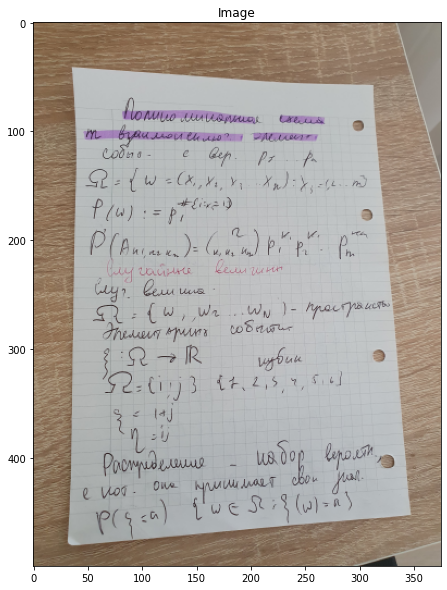

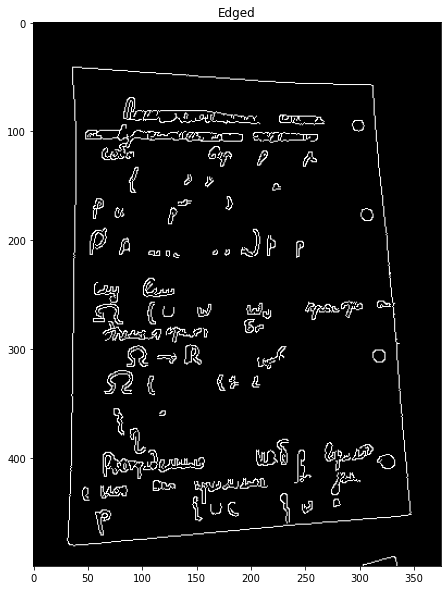

In [11]:
# загружаем изображение и вычисляем соотношение старой высоты
# к новой, копируем и изменяем размер
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread(args["image"])
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

# преобразовываем изображение в оттенки серого, размываем его и находим края
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# показываем исходное изображение и изображение с обнаруженными краями
# show the original image and the edge detected image
print("STEP 1: Edge Detection")
plt_imshow("Image", image)
plt_imshow("Edged", edged)

STEP 2: Find contours of paper


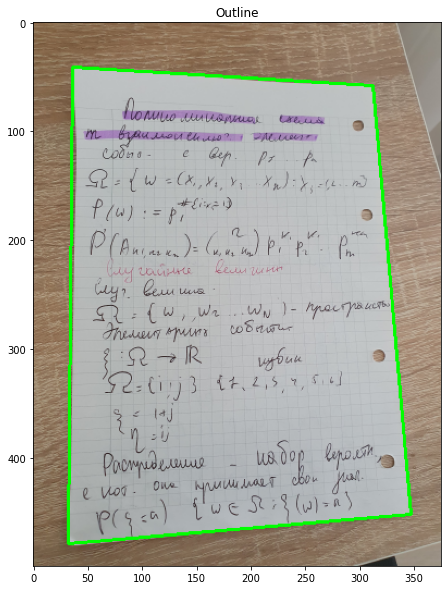

In [12]:
# находим контуры на изображении, сохраняя только
# самые большие, и инициализируем рамки будущего скрина
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# перебираем все контуры
# loop over the contours
for c in cnts:
    # аппроксимируем контур
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # если наш приближенный контур состоит из четырех точек, то мы
	# предполагаем, что нашли скан
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

# показываем контур (очертание) листка бумаги
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt_imshow("Outline", image)

STEP 3: Apply perspective transform


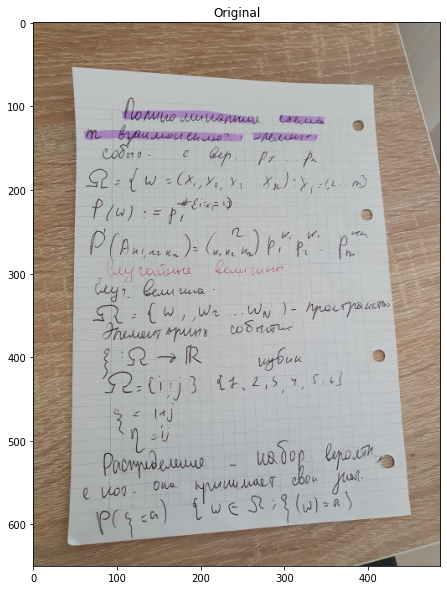

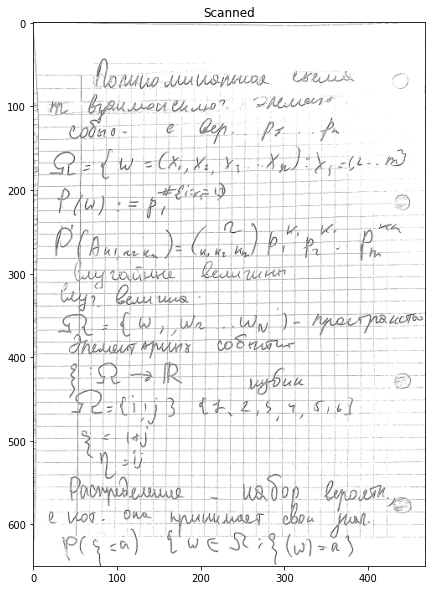

In [13]:
# применяем четырехточечное преобразование для получения вида
# сверху исходного изображения
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# конвертируем искривленное изображение в оттенки серого, затем
# придаем ему эффект «черно-белой» бумаги
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

# показываем оригинал и отсканированное изображения
# show the original and scanned images
print("STEP 3: Apply perspective transform")
plt_imshow("Original", imutils.resize(orig, height = 650))
plt_imshow("Scanned", imutils.resize(warped, height = 650))